In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn import preprocessing
from scipy import stats
import csv
import os
import sys
import logging
from keras.layers import LSTM
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import dill

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# # Keras outputs warnings using `print` to stderr so let's direct that to devnull temporarily
# stderr = sys.stderr
# sys.stderr = open(os.devnull, 'w')

# import keras

# # we're done
# sys.stderr = stderr

# from keras.backend.tensorflow_backend import tf

# import absl.logging
# logging.root.removeHandler(absl.logging._absl_handler)
# absl.logging._warn_preinit_stderr = False

# logger = tf.get_logger()
# logger.setLevel(logging.FATAL)

# graph = tf.get_default_graph()


2023-03-12 00:27:11.589415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset = read_csv('ExperimentalLakes_Data_withColorNormalizedCumulativePloading.csv', header=0, index_col=3, parse_dates=True, squeeze=False)

/var/folders/p_/hw2pplqj3rg19872qr35_y840000gn/T/ipykernel_12019/369673435.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  dataset = read_csv('ExperimentalLakes_Data_withColorNormalizedCumulativePloading.csv', header=0, index_col=3, parse_dates=True, squeeze=False)


In [3]:
ex_R = dataset[dataset.lake=='R']
ex_R = ex_R.dropna(subset=["chl"])

In [4]:
#ex_R['chl'] = (ex_R['chl'] - ex_R['chl'].min()) / (ex_R['chl'].max() - ex_R['chl'].min()) *100

In [5]:
years= sorted(list(set(ex_R['year'])))

In [6]:
years

[2008, 2009, 2010, 2011, 2013, 2014, 2015, 2018, 2019]

In [7]:
train= ex_R.loc[ex_R['year'] < years[-1]]
test= ex_R[ex_R['year']==years[-1]][:-3]
print(len(ex_R),len(train),len(test))

932 816 113


### LSTM Encoder Decoder Model

In [8]:
# convert history into inputs and outputs
def to_supervised_lstmende(data, n_input, n_out=7):
    # flatten data
    data = data.reshape(-1, 1)
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [9]:
# train the model
def build_model_lstmende(train, config):
    # define parameters
    n_input, n_nodes, n_epochs, n_batch = config
    # prepare data
    train_x, train_y = to_supervised_lstmende(train, n_input)
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    n_features, n_outputs = train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(n_nodes, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch)
    return model

In [10]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [11]:
#final evaluation
def final_eval (train, test, config):
    train_array = np.array(train['chl'])
    test_array = np.array(test['chl'])
    #train_array= train_array.reshape(-1, 1)
    #test_array= test_array.reshape(-1, 1)
    model= build_model_lstmende(train_array, config)
    test_x, test_y = to_supervised_lstmende(test_array, config[0])
    predictions = model.predict(test_x)
    score, scores= evaluate_forecasts(test_y, predictions)
    return score, scores, predictions 

In [1]:
# create a list of configs to try
def model_configs_lstmende():
    # define scope of configs
    n_input = [5, 7]
    n_nodes = [200]
    n_epochs = [10,20]
    n_batch = [1, 16]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    cfg = [i, j, k, l]
                    configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [3]:
cfig_list = model_configs_lstmende()

Total configs: 8


In [5]:
cfig_list[3]

[5, 200, 20, 16]

In [14]:
rep= 50
lstm_test_scores= []
iter= 1
for config in cfig_list:
    print(iter)
    test_scores_config = []
    for _ in range (rep):
    # final evaluate configs
        test_scores_config.append(final_eval(train, test, config))
    lstm_test_scores.append (test_scores_config)
    iter+=1


1
Epoch 1/10


2023-03-12 00:27:21.283473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


805/805 [==============================] - 3s 3ms/step - loss: 13.4078
Epoch 2/10
805/805 [==============================] - 2s 3ms/step - loss: 7.6612
Epoch 3/10
805/805 [==============================] - 2s 3ms/step - loss: 8.6991
Epoch 4/10
805/805 [==============================] - 3s 3ms/step - loss: 7.7673
Epoch 5/10
805/805 [==============================] - 2s 3ms/step - loss: 7.0903
Epoch 6/10
805/805 [==============================] - 2s 3ms/step - loss: 6.6604
Epoch 7/10
805/805 [==============================] - 2s 3ms/step - loss: 6.5714
Epoch 8/10
805/805 [==============================] - 2s 3ms/step - loss: 10.2075
Epoch 9/10
805/805 [==============================] - 2s 3ms/step - loss: 6.9340
Epoch 10/10
4/4 [==============================] - 0s 4ms/step
Epoch 1/10
805/805 [==============================] - 3s 3ms/step - loss: 15.0906
Epoch 2/10
805/805 [==============================] - 2s 3ms/step - loss: 7.9006
Epoch 3/10
805/805 [==============================] - 

In [16]:
dill.dump(lstm_test_scores, open('lstm_test_scores_unnormalized.pkd', 'wb'))

In [ ]:
all_scores = []
for i in range(len(lstm_test_scores)):
    config_scores = []
    for j in range (rep):
        overall = mlp_test_scores[i][j][0]
        scores = mlp_test_scores[i][j][1]
        config_scores.append([overall, scores])
    all_scores.append (config_scores)

In [18]:
overall_means = []
for i in range (len(all_scores)):
    Overall_scores= [all_scores[i][j][0] for j in range (rep)]
    overall_means.append(np.mean(Overall_scores))
min_overall = np.min(overall_means)
min_overall_index= overall_means.index(min_overall)
print ("Min average over all days=", min_overall, "The config with Min average=", min_overall_index)

Min average over all days= 5.578370048779207 The config with Min average= 3


In [20]:
seven_means = []
for i in range (len(all_scores)):
    sevenl_scores= [all_scores[i][j][1][6] for j in range (rep)]
    seven_means.append(np.mean(sevenl_scores))
min_7 = np.min(seven_means)
min_7_index= seven_means.index(min_7)
print ("Min 7 days (averages over iterations) over all config=", min_7, "The config with Min 7 days (averages over iterations) =", min_7_index)

Min 7 days (averages over iterations) over all config= 6.864998032078846 The config with Min 7 days (averages over iterations) = 14


In [21]:
overalls= []
for i in range (len(all_scores)):
    Overall_scores= [all_scores[i][j][0] for j in range (rep)]
    overalls.append (Overall_scores)

In [22]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [57]:
# model configs
cfig_list = model_configs_lstmende()
#grid search
lstmende_scores = grid_search_lstmende(train, cfig_list)

Total configs: 12
1
2
3
4
5
6
7
8
9
10
11
12


In [17]:
#lstmende_result = dill.load(open('lstmende_result_pet.pkd', 'rb'))

In [58]:
lstmende_result = pd.DataFrame ({'n_input' : [], 'n_nodes':[], 'n_epochs':[], 'n_batch':[], '1':[], '2':[], '3':[], '4':[], '5':[], '6':[], '7':[], 'overall_score':[]} )
for i in range(len(lstmende_scores)):
    df = {'n_input' : cfig_list[i][0], 'n_nodes':cfig_list[i][1], 'n_epochs':cfig_list[i][2], 'n_batch':cfig_list[i][3], '1':lstmende_scores[i][1][0], '2':lstmende_scores[i][1][1], '3':lstmende_scores[i][1][2], '4':lstmende_scores[i][1][3], '5':lstmende_scores[i][1][4], '6':lstmende_scores[i][1][5], '7':lstmende_scores[i][1][6], 'overall_score':lstmende_scores[i][0]}
    lstmende_result = lstmende_result.append(df, ignore_index = True)
dill.dump(lstmende_result, open('lstmende_result_pet.pkd', 'wb'))

In [59]:
lstmende_result.to_csv('lstmende_result_pet.csv', index=False)

In [60]:
lstmende_test_scores= []
iter= 1
for config in cfig_list:
    print(iter)
# final evaluate configs
    lstmende_test_scores.append(final_eval_lstmende(train, test, config))
    iter+=1

dill.dump(lstmende_test_scores, open('lstmende_test_scores_pet.pkd', 'wb'))
#mlp_test = dill.load(open('mlp_test.pkd', 'rb'))

1
2
3
4
5
6
7
8
9
10
11
12


In [61]:
# import dill
#lstmende_test_scores = dill.load(open('lstmende_test_scores.pkd', 'rb'))

In [62]:
lstmende_test = pd.DataFrame ({'n_input' : [], 'n_nodes':[], 'n_epochs':[], 'n_batch':[], '1':[], '2':[], '3':[], '4':[], '5':[], '6':[], '7':[], 'overall_score':[]} )
for i in range(len(lstmende_test_scores)):
    df = {'n_input' : cfig_list[i][0], 'n_nodes':cfig_list[i][1], 'n_epochs':cfig_list[i][2], 'n_batch':cfig_list[i][3], '1':lstmende_test_scores[i][1][0], '2':lstmende_test_scores[i][1][1], '3':lstmende_test_scores[i][1][2], '4':lstmende_test_scores[i][1][3], '5':lstmende_test_scores[i][1][4], '6':lstmende_test_scores[i][1][5], '7':lstmende_test_scores[i][1][6], 'overall_score':lstmende_test_scores[i][0]}
    lstmende_test = lstmende_test.append(df, ignore_index = True)

dill.dump(lstmende_test, open('lstmende_test_pet.pkd', 'wb'))
lstmende_test.to_csv('lstmende_test_pet.csv', index=False)

### Test predictions for best cases

In [63]:
selected= pd.DataFrame()
selected= selected.append(lstmende_test[lstmende_test['overall_score']== lstmende_test.overall_score.min()])
selected = selected.append(lstmende_test[lstmende_test['7']== lstmende_test['7'].min()])
selected = selected.append(lstmende_result[lstmende_result['overall_score']== lstmende_result['overall_score'].min()])
selected = selected.append(lstmende_result[lstmende_result['7']== lstmende_result['7'].min()])

In [64]:
dill.dump(selected, open('selected_lstmende_pet.pkd', 'wb'))
selected.to_csv('selected_lstmende_pet.csv', index=False)

In [65]:
selected

,n_input,n_nodes,n_epochs,n_batch,1,2,3,4,5,6,7,overall_score
1,5.0,200.0,50.0,16.0,6.726762,9.182590,11.015434,12.174126,13.205060,14.424368,15.720310,12.122490
7,7.0,200.0,50.0,16.0,7.703833,9.608281,11.245682,12.791022,13.610624,14.193560,15.157443,12.295167
6,7.0,200.0,50.0,1.0,6.607758,8.337357,9.832648,10.893524,12.483265,13.613047,14.575525,11.225716
6,7.0,200.0,50.0,1.0,6.607758,8.337357,9.832648,10.893524,12.483265,13.613047,14.575525,11.225716


In [66]:
selected_configs = []
for index, row in selected.iterrows():
    config = [int(row['n_input']), int(row['n_nodes']), int(row['n_epochs']), int(row['n_batch'])]
    selected_configs.append(config)

In [67]:
#Best 7 Days, Best Overall Test, Best Validation, Best 7 Days Valid
final_predics= []
iter= 1
for config in selected_configs:
    print(iter)
# final evaluate configs
    final_predics.append(final_eval_lstmende(train, test, config)[2])
    iter+=1

1
2
3
4


In [68]:
dill.dump(final_predics, open('lstmende_final_predics_pet.pkd', 'wb'))

In [85]:
selected_configs

[[5, 200, 50, 16], [7, 200, 50, 16], [7, 200, 50, 1], [7, 200, 50, 1]]

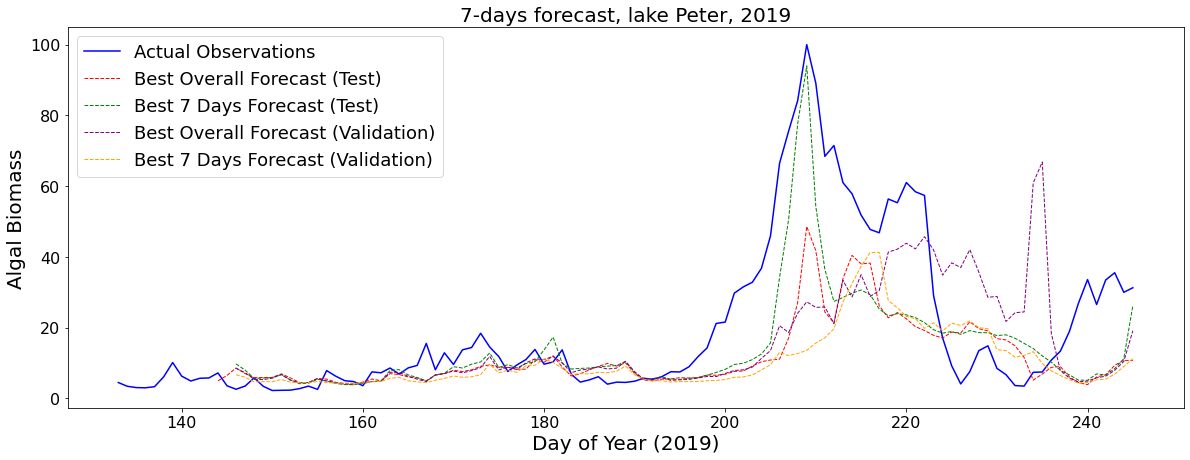

In [70]:
y= np.array(test['chl'])
x = test.doy
plt.figure(figsize=(20,7))
plt.plot(x, y, label="Actual Observations", color='Blue', linewidth=1.5)
plt.plot(x[selected_configs[0][0]+6:], final_predics[0][:,6], label="Best Overall Forecast (Test)", color='Red', linewidth=1 , linestyle='dashed')
plt.plot(x[selected_configs[1][0]+6:], final_predics[1][:,6], label="Best 7 Days Forecast (Test)", color='Green', linewidth=1 , linestyle='dashed')
plt.plot(x[selected_configs[2][0]+6:], final_predics[2][:,6], label="Best Overall Forecast (Validation)", color='purple', linewidth=1 , linestyle='dashed')
plt.plot(x[selected_configs[3][0]+6:], final_predics[3][:,6], label="Best 7 Days Forecast (Validation)", color='orange', linewidth=1 , linestyle='dashed')

#plt.plot(x[7:], y[:-7], label="Naive Forecast", color='Grey', linestyle='dashed',linewidth=1)
plt.title("7-days forecast, lake Peter, 2019", fontsize=20)
plt.xlabel('Day of Year (2019)',fontsize=20)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.ylabel('Algal Biomass',fontsize=20)
plt.legend(fontsize=18, loc=2)
#plt.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/comparison paper/Figures/7-days forecast, lake Peter, 2019_slides.jpeg')
plt.show()

In [91]:
n_input= 7
y= np.array(test['chl'])
x = test.doy
Predict_lstm= pd.DataFrame ({'doy':[], 'actual':[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]})
Predict_lstm['doy'] = test.doy
Predict_lstm['actual'] = test.chl
for i in range (6):
    Predict_lstm[i+1].iloc[n_input+i:-6+i] = final_predics[1][:,i].reshape(100,)
Predict_lstm[7].iloc[n_input+6:] = final_predics[1][:,6].reshape(100,)
Predict_lstm.to_csv('Predict_lstm.csv', index=False)

In [28]:
final_config= [7,200,50,16]
score= []
scores=[]
predictions= []
for _ in range(100):
    a, b, c= final_eval_lstmende(train, test, final_config)
    score.append(a)
    scores.append(b)
    predictions.append(c)
    

In [38]:
mean_score= np.mean(score)
mean_scores= []
mean_predictions=[]
for i in range(6):
    mean_scores.append(np.mean(np.array(scores)[:,i]))
for j in range (len(predictions[0])):
    mean_predictions.append(np.mean(np.array(predictions)[:,j]))
    

In [39]:
len(predictions[0])

100

In [40]:
mean_score

13.736368681579686

In [41]:
mean_scores

[8.407862011163182,
 10.833339198275032,
 12.9121178214941,
 14.35670521100105,
 15.249930039920715,
 15.819357239202283]

In [44]:
len(mean_predictions)

100

In [45]:
np.array(predictions)[:,0]

array([[[ 8.573339 ],
        [ 8.812508 ],
        [ 8.98677  ],
        [ 9.039962 ],
        [ 9.077421 ],
        [ 9.157048 ],
        [ 9.2717905]],

       [[ 8.47669  ],
        [ 8.461285 ],
        [ 8.260926 ],
        [ 8.281218 ],
        [ 8.364391 ],
        [ 8.47164  ],
        [ 8.568724 ]],

       [[ 8.828132 ],
        [ 9.190783 ],
        [ 9.568924 ],
        [ 9.791975 ],
        [ 9.884546 ],
        [ 9.922785 ],
        [ 9.929134 ]],

       [[ 8.3779   ],
        [ 8.880239 ],
        [ 9.271176 ],
        [ 9.4911995],
        [ 9.683005 ],
        [ 9.901431 ],
        [10.177899 ]],

       [[ 7.6912007],
        [ 7.7726836],
        [ 7.7999725],
        [ 7.922729 ],
        [ 8.0429325],
        [ 8.16569  ],
        [ 8.311676 ]],

       [[ 8.685394 ],
        [ 9.0014305],
        [ 9.064142 ],
        [ 9.164236 ],
        [ 9.236267 ],
        [ 9.309624 ],
        [ 9.384544 ]],

       [[ 8.213559 ],
        [ 8.37626  ],
        [ 8.704292 ]